# Football and Manchester United

As a Manchester United supporter

For this analysis, I am using data from the Open Football project, which provides open public domain football data in CSV format (https://footballcsv.github.io/) for download. The Open Football project provides data from many leagues across the world, however, I will be focusing on the top division of English football for which data is provided between most of the years between 1888 to 2020.

This project demonstrates the following:

A. Preparing the dataset
- Creating the desired dataset(s) - creating functions which create pandas dataframes for any variation of English top division seasons.
- Cleaning and enhancing the dataset - dealing with missing data and enhancing the dataset by adding additional information inferred from the existing data.
- Filtering the data - adding functions which filter the data by team results, matchups, and adding team-specific statistics.

B. Analysing the Data with Visual Representation
- Goals scored over time
- Relative strengths of winners and losers over time
- Home advantage

C. Analysing the Sir Alex Ferguson era
- How successful was the Sir Alex Ferguson era of Manchester United (1986-2013)? How does it compare to the years since?
- Does Manchester United live up to their reputation as comeback kings?

D. Final Thoughts (visualised)

# A. Preparing the dataset

There are a number of wrinkles with the data that will require some adjustments before we can begin the analysis proper.

## Creating the desired dataset(s)
Firstly, the download provides CSV files for each available season in separate folders - by decade, season, and then finally CSV files for each division. 

For example, the path to the CSV file containing results from the 2019-20 season of the English Premier League (the top division of English football) is:

> */path to folder/England-master/2010s/2019-20/eng.1.csv*

For flexibility, we want to be able to access any individual season for which there is data, as well as the ability to merge them into a single dataset.

For this purpose, we have a function that populates a dictionary with the correct paths for each CSV:

In [205]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

#This creates a dictionary with paths to each season's CSV file. You can modify the number of seasons by decade.
def seasons_dictionary(starting_decade, ending_decade):
    eng = 'D:\Google Drive\\New Dropbox\Work stuff\Professional Development\Data Projects\Football_python\england-master'
    #Populate a dictionary with a string like '2010s' as the key and a string like '2010-11' as the value
    seasons = {}
    for i in range(int(abs((starting_decade - ending_decade)/10)) + 1):
        decade = starting_decade
        decade_string = str(decade) + 's'
        list_of_seasons = []
        for i in range(10):
            season = str(decade + i) + '-' + str(decade + i + 1)[2:4]
            list_of_seasons.append(season)
            seasons[decade_string] = list_of_seasons
        starting_decade += 10
    #Using the dictionary above, populate another dictionary with a string like 'df_eng_2010-11" as the key, and the path to the file for the 2010-11 season as the value.
    df_dictionary = {}
    for decade in seasons:
        for season in seasons[decade]:
            path = eng + '\\' + decade + '\\' + season + '\eng.1.csv'
            df_name = 'df_eng_' + season
            df_dictionary[df_name] = path
    return df_dictionary

#To return the paths for every season in the 2010s:
seasons_dictionary(2010, 2010)

{'df_eng_2010-11': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2010-11\\eng.1.csv',
 'df_eng_2011-12': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2011-12\\eng.1.csv',
 'df_eng_2012-13': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2012-13\\eng.1.csv',
 'df_eng_2013-14': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2013-14\\eng.1.csv',
 'df_eng_2014-15': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2014-15\\eng.1.csv',
 'df_eng_2015-16': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2015-16\\eng.1.csv',
 'df_eng_2

Using the dictionary produced by this function, we can then specify any individual season (CSV file) to read in to a pandas dataframe.

In [206]:
#Creates a data frame from the CSV file of the specified season
def create_df(season):
    all_seasons = seasons_dictionary(1880, 2010)
    all_seasons['df_eng_' + season]
    df = pd.read_csv(all_seasons['df_eng_' + season])
    return df

#for the sake of readability, this function will display a certain amount of rows in the df
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)

#For example, here's a snapshot of the 2014-15 Premier League season:
EPL_14_15 = create_df('2014-15')
display_n(EPL_14_15, 2)

,Round,Date,Team 1,FT,HT,Team 2
0,?,(Sat) 16 Aug 2014 (W33),Arsenal FC (1),2-1,1-1,Crystal Palace FC (1)
1,?,(Sat) 16 Aug 2014 (W33),Leicester City FC (1),2-2,1-2,Everton FC (1)
...,...,...,...,...,...,...
378,?,(Sun) 24 May 2015 (W21),Newcastle United FC (38),2-0,0-0,West Ham United FC (38)
379,?,(Sun) 24 May 2015 (W21),Stoke City FC (38),6-1,5-0,Liverpool FC (38)


We also want to be able to look at more than a single season, even though the data is contained in separate CSV files. Building on the seasons_dictionary function again, we can read in and merge the CSV files for multiple seasons. To delineate the data for each season, we will also add a column for each season's dataframe before we merge them together. 

Note that not every year has data. There were interruptions to professional football, most notably during the years of the World Wars. The function has accommodated for this with error handling.

Below, we use the merge_df function below to create a data frame containing *all* the available data for top flight English football, from the 1888-89 seasons to the 2019-20 season.

In [207]:
#Finally, this function reads in any number of season datasets as specified in the argument, and merges them into a single dataframe
def merge_df(start_season, end_season):
    df_dictionary = seasons_dictionary(1880, 2010)
    df_list = []
    seasons_list = []
    #Identify the index of the starting season and ending season specified
    start_index = list(df_dictionary.keys()).index('df_eng_' + start_season)
    end_index = (list(df_dictionary.keys()).index('df_eng_' + end_season)) + 1
    #Loop through these indices to populate the seasons_list with the desired keys for seasons_dictionary
    for i in range(start_index, end_index):
        season_key = list(df_dictionary.keys())[i]
        seasons_list.append(season_key)
    #Use the keys in seasons_list to fetch the paths to each season, and reading them in to a list of dfs in df_list
    for i in df_dictionary:
        if i in seasons_list:
            try:
                df = pd.read_csv(df_dictionary[i], index_col=None, header=0)
    #While we're at it, use regex to isolate the season for each CSV file, and add it as a column to the dataframe before appending it to df_list
                season = re.findall(r'\d\d\d\d-\d\d', i)[0]
                df['Season'] = season
                df_list.append(df)
            except FileNotFoundError: #This exception accommodates the fact that data is not available for all years - for example, seasons that were not played due to WW1 and WW2.
                continue
    #Finally, merge the dfs in df_list into a single df
    merged_df = pd.concat(df_list, axis =0, ignore_index=True)
    return merged_df

#Let's make use of all the available data, from the 1888-89 season to the current 2019-20 season.
merged_df = merge_df('1888-89', '2019-20')
display_n(merged_df, 2)

,Round,Date,Team 1,FT,HT,Team 2,Season
0,?,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89
1,?,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89
...,...,...,...,...,...,...,...
48989,?,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20
48990,?,(Mon) 9 Mar 2020 (W11),Leicester City FC (29),4-0,1-0,Aston Villa FC (28),2019-20


As we can see, the merged dataset starts on the 8th September 1888 and it ends 48,991 games and 132 years later, with a game on 9th March 2020.

## Cleaning and enhancing the dataset

Now that we have the means to quickly and easily create different datasets from the data we have available, there is some cleaning to do:

- The dataset has missing data in the "Round" and "HT" columns. They are marked by the '?' symbol.
- The FT (full time) and HT (half time) scores are represented as strings, not numbers.
- We must infer the goals scored by the home and away teams by the order of the string. '4-0' means the home team scored 4 goals to the away team scored 0 goals.

It would be nice (and much more useful) to be able to deal with these scores as numbers, and to have the goals explicitly attributed to the home or away teams.

To clean and enhance the dataset, we will need to:
- Get rid of the "Round" column - the vast majority of seasons have missing data for this column, and it is useless for our analysis.
- Add some columns which provide ways for us to cut the data, such as the number of goals scored by the home vs. away teams, the total number of goals scored, as well as goals scored in the first half vs. the second half.
- Find a way to handle the missing half-time scores when it comes to statistics which rely on that information.

In [208]:
#Let's add some additional columns with data that will be useful for analysis
def add_columns(dataframe):
    df = dataframe
    #The below converts a string '2-1' to a list [2,1] for the FT and HT columns
    FT_score_list = df['FT'].map(lambda FT: re.findall(r'\d+', FT)) 
    HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
    #Now that we have the scores in a list format, we can convert them to integers and play with them to create the following additional statistics:
    df['Total goals'] = FT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]))
    df['Home goals'] = FT_score_list.map(lambda goals: int(goals[0]))
    df['Away goals'] = FT_score_list.map(lambda goals: int(goals[1])) 
    df['First half goals'] = HT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]) if goals != [] else np.NaN) #The if/else condition is necessary because for many games the HT result is missing. They are marked as NaN if so.
    df['Second half goals'] = df['Total goals'] - df['First half goals']
    #Finally, delete the useless "round" column
    df = df.drop(columns=['Round'])
    return df

merged_df = add_columns(merged_df)
display_n(merged_df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
0,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89,9,3,6,NaN,NaN
1,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89,2,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
48989,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20,2,2,0,1.0,1.0
48990,(Mon) 9 Mar 2020 (W11),Leicester City FC (29),4-0,1-0,Aston Villa FC (28),2019-20,4,4,0,1.0,3.0


## Filtering the data for analysis of teams

Again, it would be useful to have some way to quickly isolate certain information to allow for the analysis of a particular team's performance. Additional team-specific statistics must also be added. It would be great if we could:
- Analyse a particular team's performance by looking up their results.
- Look up particular matchups between two teams.
- Add team-specific information such as the goals scored by the team, goals scored against the team, and to identify whether they are scored in the first or second half (where HT stats are available). Moreover, we can infer wins, losses, and draws.

Let's start with a function that will find a particular team's games (specified by the 'name' argument) over any given period (specified by the 'df' argument). We want it to be able to find multiple teams if necessary.

In [209]:
#Look up a particular team's fixtures, it will take any number of team names as arguments, to create a df with all those team's fixtures across a given period of time.
def find_team_games(df, *team_names):
    team_games = []
    for team in team_names:
        games = df.loc[(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True) | (df['Team 2'].str.contains(team, re.compile('(\d)|(\d\d)')) == True)]
        team_games.append(games)
    merged_df = pd.concat(team_games, axis =0, ignore_index=True)
    return merged_df

#Let's find Manchester United's results 
df = find_team_games(merged_df,'Manchester United')
display_n(df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
0,(Sat) 3 Sep 1892 (35),Blackburn Rovers FC (1),4-3,?,Manchester United FC (1),1892-93,7,4,3,NaN,NaN
1,(Sat) 10 Sep 1892 (36),Manchester United FC (2),1-1,?,Burnley FC (3),1892-93,2,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3808,(Sun) 1 Mar 2020 (W9),Everton FC (28),1-1,1-1,Manchester United FC (28),2019-20,2,1,1,2.0,0.0
3809,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20,2,2,0,1.0,1.0


Next, let's create a function that will make a dataframe for games against two particular teams. Again the 'df' argument specifies the time period, and 'team1' and 'team2' the two teams in the matchup.

In [210]:
#Look up the fixtures for a particular matchup
def find_matchups(df, team1, team2):
    matchups = df.loc[(df['Team 1'].str.contains((team1), re.compile('(\d)|(\d\d)')) == True) & (df['Team 2'].str.contains((team2), re.compile('(\d)|(\d\d)')) == True) | (df['Team 1'].str.contains((team2), re.compile('(\d)|(\d\d)')) == True) & (df['Team 2'].str.contains((team1), re.compile('(\d)|(\d\d)')) == True)]
    return matchups

#Let's look at the games between Manchester United and Liverpool
north_west_derby = find_matchups(merged_df, 'Manchester United', 'Liverpool')
display_n(north_west_derby, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
4725,(Tue) 25 Dec 1906 (52),Manchester United FC (19),0-0,?,Liverpool FC (19),1906-07,0,0,0,NaN,NaN
4867,(Mon) 1 Apr 1907 (13),Liverpool FC (33),0-1,?,Manchester United FC (34),1906-07,1,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
48791,(Sun) 20 Oct 2019 (W42),Manchester United FC (9),1-1,1-0,Liverpool FC (9),2019-20,2,1,1,1.0,1.0
48931,(Sun) 19 Jan 2020 (W3),Liverpool FC (22),2-0,1-0,Manchester United FC (23),2019-20,2,2,0,1.0,1.0


Finally, let's add team-specific information to go with our team-specific dataframes. The below function uses the find_team_games function above so we can create the desired team-specific dataframe and the additional statistics in one go.

In [211]:
def team_stats(dataframe, team):
    #Create a df with the team's fixtures only
    df = find_team_games(dataframe, team)
    #Add team-specific stats as columns to the df
    df['Team goals'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
    HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
    df['Team goals (1st half)'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
    df['Team goals (2nd half)'] = df['Team goals'] - df['Team goals (1st half)']
    df['Goals against'] = df['Total goals'] - df['Team goals']
    df['Goals against (1st half)'] = df['First half goals'] - df['Team goals (1st half)']
    df['Goals against (2nd half)'] = df['Second half goals'] - df['Team goals (2nd half)']
    df['Goal difference'] = df['Team goals'] - df['Goals against']
    df['Result'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],['Win', 'Loss'], default = 'Draw')
    df['Points'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],[3, 0], default = 1)
    return df

manchester_united = team_stats(merged_df, 'Manchester United')
display_n(manchester_united, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
0,(Sat) 3 Sep 1892 (35),Blackburn Rovers FC (1),4-3,?,Manchester United FC (1),1892-93,7,4,3,NaN,NaN,3,NaN,NaN,4,NaN,NaN,-1,Loss,0
1,(Sat) 10 Sep 1892 (36),Manchester United FC (2),1-1,?,Burnley FC (3),1892-93,2,1,1,NaN,NaN,1,NaN,NaN,1,NaN,NaN,0,Draw,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3808,(Sun) 1 Mar 2020 (W9),Everton FC (28),1-1,1-1,Manchester United FC (28),2019-20,2,1,1,2.0,0.0,1,1.0,0.0,1,1.0,0.0,0,Draw,1
3809,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20,2,2,0,1.0,1.0,2,1.0,1.0,0,0.0,0.0,2,Win,3


# B. Analysing the Data

With a large historical dataset and some additional columns of information, we can now begin exploring the data at a high level. Here, we will check for statistical trends by visualising the data using the matplotlib library.
- Are there any discernable trends in terms of goals scored - were teams in the olden days more or less prolific?
- Were teams more or less dominant? Was the gap between winners and losers bigger or smaller?
- What was the most common result, and how has that changed over time?
- Has 'home' advantage increased over time?

Let's begin exploring the first question by looking at the number of goals scored over time.

## Goals scored over time

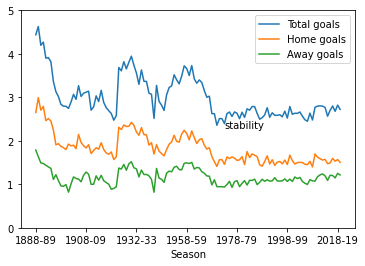

In [212]:
df = add_columns(merge_df('1888-89', '2019-20'))
df.groupby(['Season']).agg({'Total goals': 'mean', 'Home goals': 'mean', 'Away goals': 'mean'}).plot.line()
plt.ylim(0,5)
plt.annotate('stability', (75, 2.3))
plt.show()

We saw that since 1888, the average number of goals scored per game in the top flight of English football has decreased dramatically. From averaging almost 5 goals per game down to just under 3 goals per game in recent years. However, over the course of history we see that the trend is not linear, and that for about the first 75 years, goals per game is volatile. After, the number of goals begins to stabilise, and has gradually seen a subtle upwards trend over the past 50 or so years.

Looking at the breakdown of goals per game by goals scored by the home team vs. the away team, we see that home advantage also seems to be eroding as the modern game has become professionalised.

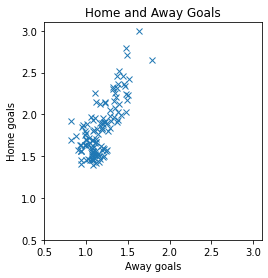

In [213]:
df = add_columns(merge_df('1888-89', '2019-20'))
df = df.groupby(['Season'], as_index = False).agg({'Away goals': 'mean', 'Home goals': 'mean'})

plt.figure().add_subplot().set_aspect('equal', adjustable = 'box')
plt.xlim(0.5,3.1)
plt.ylim(0.5,3.1)
plt.plot('Away goals', 'Home goals', data = df, linestyle = 'none', marker = 'x')
plt.title('Home and Away Goals')
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.show()

## Looking at the Premier League era

Using the flexibility afforded by the functions, we can quickly examine snapshots within the dataset. Let's look at the current iteration of the English top division, the Premier League, which had it's inaugural season in 1992-93.

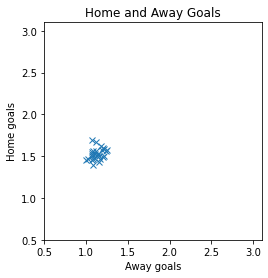

In [214]:
#Make a df starting from the inaugural season of the English Premier League
EPL = add_columns(merge_df('1992-93', '2019-20'))

EPL = EPL.groupby(['Season'], as_index = False).agg({'Away goals': 'mean', 'Home goals': 'mean'})

plt.figure().add_subplot().set_aspect('equal', adjustable = 'box')
plt.plot('Away goals', 'Home goals', data = EPL, linestyle = 'none', marker = 'x')
plt.title('Home and Away Goals')
plt.xlim(0.5,3.1)
plt.ylim(0.5,3.1)
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.show()

# C. The Sir Alex Ferguson Era

On 6th November 1986, Alex Ferguson was appointed the new manager of Manchester United. He would go on to manage the club for 27 years, leaving behind an era of unprecedented success in the domestic league.

While the Ferguson era was wildly successful, some analysis will illuminate just how successful and unprecedented this was. We will explore the following areas:
- Manchester United is known for attacking play and throwing caution to the wind - how true is this?
- Known for thrilling late comebacks and a never-say-die attitude


Let's start by creating a dataset of this era, from the 1986-87 to 2012-13 seasons, and adding in our team-specific data.

In [215]:
eng_1986_87_to_2012_13 = merge_df('1986-87', '2012-13')
eng_1986_87_to_2012_13 = find_team_games(eng_1986_87_to_2012_13, 'Manchester United').reset_index(drop=True)
#Note that Ferguson's first game in charge was the 8th November 1986, a few months into the season. Let's filter out those first few games in the 86-87 season.
saf_era = add_columns(eng_1986_87_to_2012_13[13:])
#Now let's add team statistics for Ferguson's United teams
saf_era = team_stats(saf_era, 'Manchester United')
display_n(saf_era, 3)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
0,(Sat) 8 Nov 1986 (44),Oxford United FC (14),2-0,?,Manchester United FC (14),1986-87,2,2,0,NaN,NaN,0,NaN,NaN,2,NaN,NaN,-2,Loss,0
1,(Sat) 15 Nov 1986 (45),Norwich City FC (15),0-0,?,Manchester United FC (15),1986-87,0,0,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,Draw,1
2,(Sat) 22 Nov 1986 (46),Manchester United FC (16),1-0,?,Queens Park Rangers FC (16),1986-87,1,1,0,NaN,NaN,1,NaN,NaN,0,NaN,NaN,1,Win,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,(Sun) 5 May 2013 (W18),Manchester United FC (36),0-1,0-0,Chelsea FC (35),2012-13,1,0,1,0.0,1.0,0,0.0,0.0,1,0.0,1.0,-1,Loss,0
1033,(Sun) 12 May 2013 (W19),Manchester United FC (37),2-1,1-0,Swansea City AFC (37),2012-13,3,2,1,1.0,2.0,2,1.0,1.0,1,0.0,1.0,1,Win,3
1034,(Sun) 19 May 2013 (W20),West Bromwich Albion FC (38),5-5,1-3,Manchester United FC (38),2012-13,10,5,5,4.0,6.0,5,3.0,2.0,5,1.0,4.0,0,Draw,1


## The United Way

Now let's look at some visualisations which will help us explore the first question.

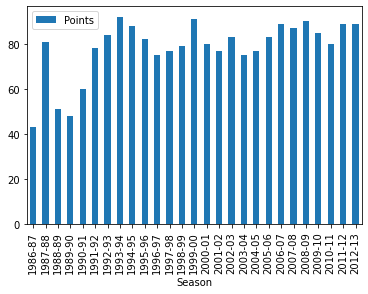

In [216]:
eng_1986_87_to_2012_13 = merge_df('1986-87', '2012-13')
eng_1986_87_to_2012_13 = find_team_games(eng_1986_87_to_2012_13, 'Manchester United').reset_index(drop=True)
#Note that Ferguson's first game in charge was the 8th November 1986, a few months into the season. Let's filter out those first few games in the 86-87 season.
saf_era = add_columns(eng_1986_87_to_2012_13[13:])
#Now let's add team statistics for Ferguson's United teams
saf_era = team_stats(saf_era, 'Manchester United')
saf_era.groupby(['Season']).agg({'Points': 'sum'}).plot.bar()
plt.show()

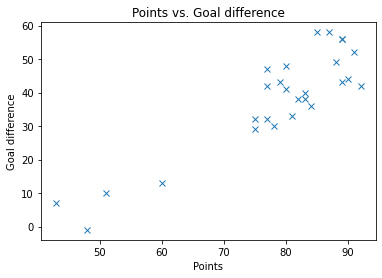

In [217]:
chart = saf_era.groupby(['Season']).agg({'Points': 'sum', 'Goal difference': 'sum'})
plt.plot('Points', 'Goal difference', data = chart, linestyle = 'none', marker = 'x')
plt.title('Points vs. Goal difference')
plt.xlabel('Points')
plt.ylabel('Goal difference')
plt.show()

Text(0, 0.5, 'Season')

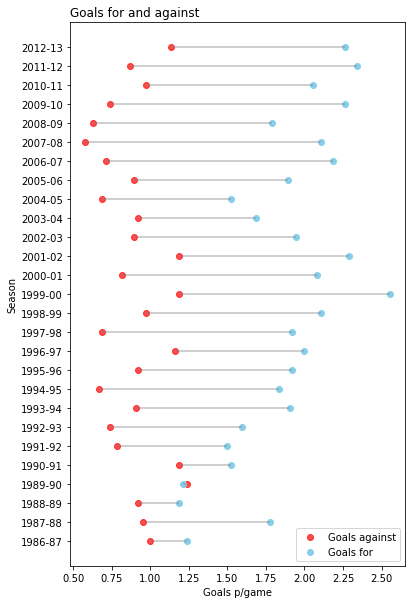

In [218]:
saf_era = saf_era.groupby(['Season'], as_index = False).agg({'Team goals': 'mean', 'Goals against': 'mean'})
season = saf_era['Season']

plt.figure(figsize = (6,10))
plt.hlines(y = season, xmin = saf_era['Goals against'], xmax = saf_era['Team goals'], color='grey', alpha=0.5)
plt.scatter(saf_era['Goals against'], season, color = 'red', alpha = 0.7, label = 'Goals against')
plt.scatter(saf_era['Team goals'], season, color = 'skyblue', alpha = 1, label = 'Goals for')
plt.legend()

plt.yticks(season, saf_era['Season'])
plt.title('Goals for and against', loc = 'left')
plt.xlabel('Goals p/game')
plt.ylabel('Season')

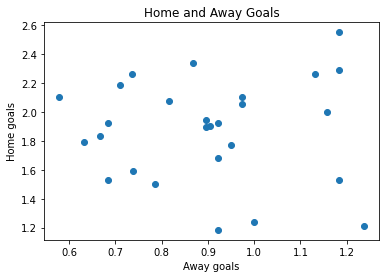

In [219]:
saf_era = saf_era.groupby(['Season'], as_index = False).agg({'Team goals': 'mean', 'Goals against': 'mean'})

plt.plot('Goals against', 'Team goals', data = saf_era, linestyle = 'none', marker = 'o')
plt.title('Home and Away Goals')
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.show()

## Comeback Kings

# Final Thoughts (visualised)